# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
sns.set_palette("vlag")

%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.simplefilter('ignore')

# Import Data

In [2]:
funds = pd.read_csv('data/index_funds_data.csv')

In [3]:
funds.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,NASDX,2017-01-12 00:00:00+00:00,12.87,12.87,12.87,12.87,0.0,11.067007,11.067007,11.067007,11.067007,0.0,0.0,1.0
1,NASDX,2017-01-13 00:00:00+00:00,12.92,12.92,12.92,12.92,0.0,11.110002,11.110002,11.110002,11.110002,0.0,0.0,1.0
2,NASDX,2017-01-14 00:00:00+00:00,12.88,12.88,12.88,12.88,0.0,11.075606,11.075606,11.075606,11.075606,0.0,0.0,1.0
3,NASDX,2017-01-15 00:00:00+00:00,12.88,12.88,12.88,12.88,0.0,11.075606,11.075606,11.075606,11.075606,0.0,0.0,1.0
4,NASDX,2017-01-16 00:00:00+00:00,12.88,12.88,12.88,12.88,0.0,11.075606,11.075606,11.075606,11.075606,0.0,0.0,1.0


In [4]:
funds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23725 entries, 0 to 23724
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       23725 non-null  object 
 1   date         23725 non-null  object 
 2   close        23725 non-null  float64
 3   high         23725 non-null  float64
 4   low          23725 non-null  float64
 5   open         23725 non-null  float64
 6   volume       23725 non-null  float64
 7   adjClose     23725 non-null  float64
 8   adjHigh      23725 non-null  float64
 9   adjLow       23725 non-null  float64
 10  adjOpen      23725 non-null  float64
 11  adjVolume    23725 non-null  float64
 12  divCash      23725 non-null  float64
 13  splitFactor  23725 non-null  float64
dtypes: float64(12), object(2)
memory usage: 2.5+ MB


In [5]:
funds['date'] = pd.to_datetime(funds['date'],infer_datetime_format=True)

In [6]:
funds = funds[['symbol','date','close']]

In [7]:
funds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23725 entries, 0 to 23724
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   symbol  23725 non-null  object             
 1   date    23725 non-null  datetime64[ns, UTC]
 2   close   23725 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 556.2+ KB


In [8]:
funds = funds.set_index(['symbol','date'])

In [9]:
funds.head()

close
symbol date                            
NASDX  2017-01-12 00:00:00+00:00  12.87
       2017-01-13 00:00:00+00:00  12.92
       2017-01-14 00:00:00+00:00  12.88
       2017-01-15 00:00:00+00:00  12.88
       2017-01-16 00:00:00+00:00  12.88

### Looking at growth over 5 years

In [10]:
tickers = list(set([ticker[0] for ticker in funds.index]))

In [11]:
five_yr_rois = []
for tick in tickers:
    ticker_closing = funds.loc[tick,['close']]
    roi = (((ticker_closing.iloc[-1]-ticker_closing.iloc[0].values)/ticker_closing.iloc[0].values)*100)[0]
    five_yr_rois.append(roi)
five_yr_rois

[169.6192696192697,
 -19.907749077490784,
 165.56158152554232,
 104.94801947624688,
 103.84905660377359,
 101.59929701230229,
 105.73419850997354,
 81.52955974842769,
 104.72373318064703,
 105.67189810618709,
 99.13215968261841,
 105.4959617070408,
 209.68714355548315]

In [12]:
roi_series = pd.Series(five_yr_rois,index=tickers)

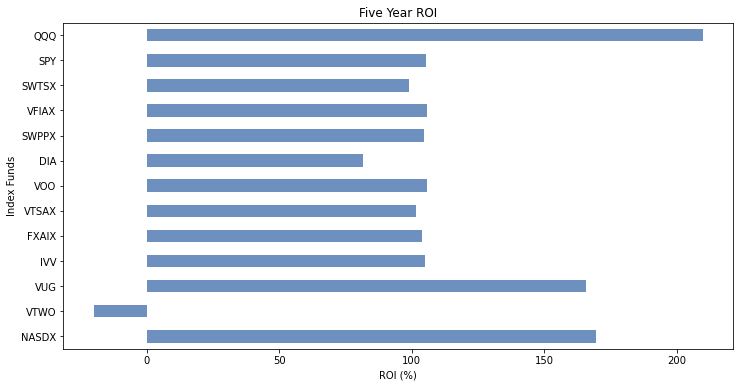

In [13]:
# Plotting ROIs
fig, ax = plt.subplots(figsize=(12,6))
roi_series.plot.barh(ax=ax)
ax.set_title("Five Year ROI")
ax.set_xlabel("ROI (%)")
ax.set_ylabel("Index Funds");

In [14]:
# Pulling individual series for each index fund

NASDX = funds.loc['NASDX',['close']]
QQQ = funds.loc['QQQ',['close']]
VOO = funds.loc['VOO',['close']]
SPY = funds.loc['SPY',['close']]
VTWO = funds.loc['VTWO',['close']]
IVV = funds.loc['IVV',['close']]
SWPPX = funds.loc['SWPPX',['close']]
DIA = funds.loc['DIA',['close']]
VFIAX = funds.loc['VFIAX',['close']]
VTSAX = funds.loc['VTSAX',['close']]
FXAIX = funds.loc['FXAIX',['close']]
SWTSX = funds.loc['SWTSX',['close']]
VUG = funds.loc['VUG',['close']]

### Check Stationarity of time series

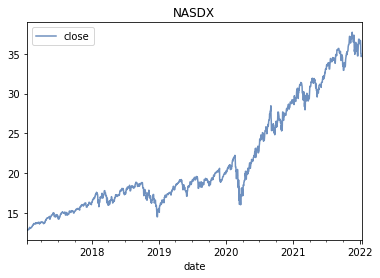

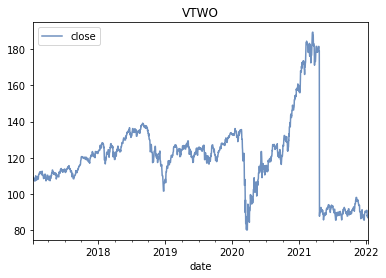

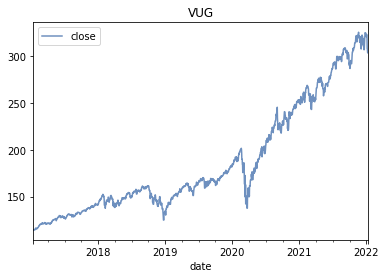

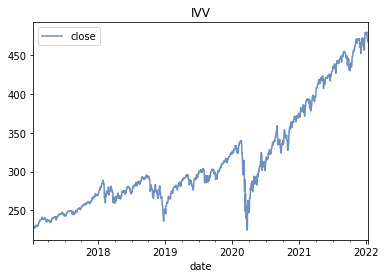

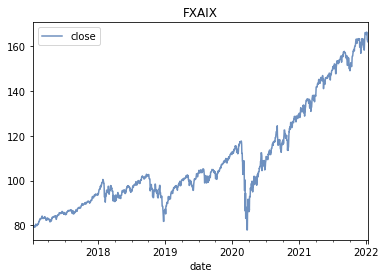

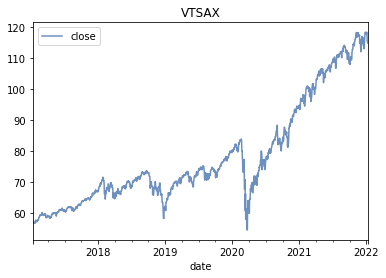

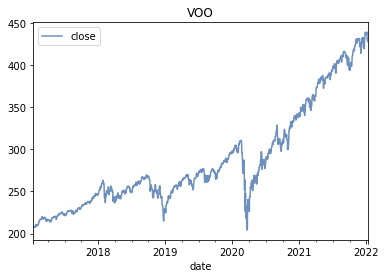

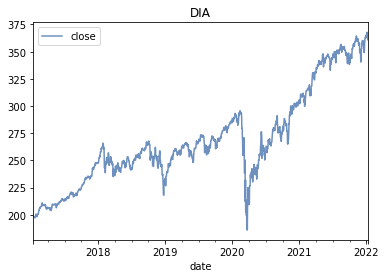

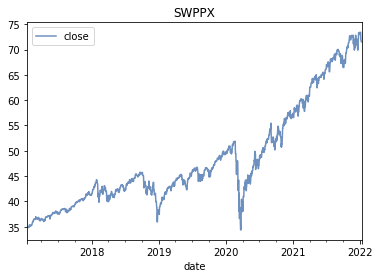

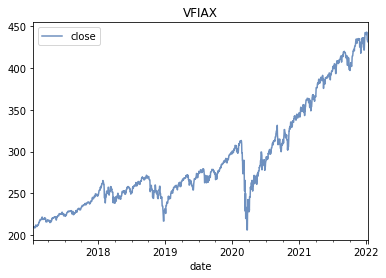

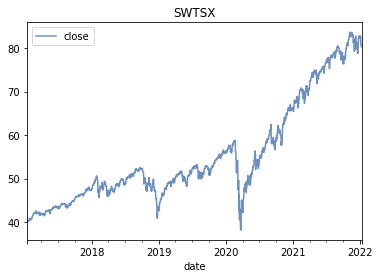

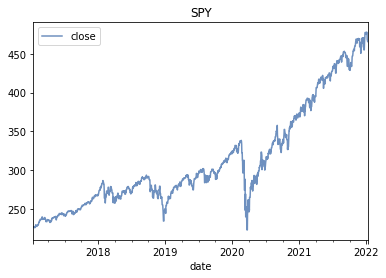

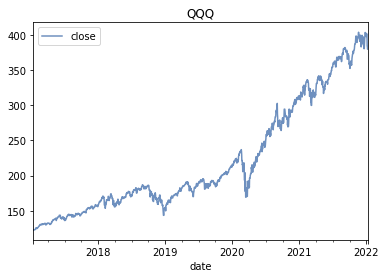

In [15]:
for ticker in tickers:
    funds.loc[ticker,['close']].plot()
    plt.title(str(ticker))
    plt.show()

In [16]:
def check_stationarity(ts):
    #Determing rolling statistics
    roll_mean = ts.rolling(30).mean()
    roll_std = ts.rolling(30).std()
    #Plot rolling statistics:
    plt.plot(ts, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(ts,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    return ""

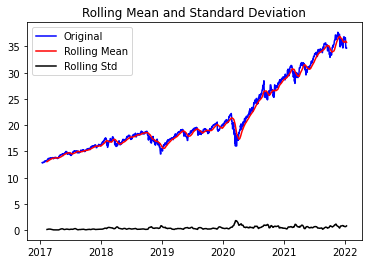

Results of dickey fuller test
Test Statistics                   0.094800
p-value                           0.965704
No. of lags used                 14.000000
Number of observations used    1810.000000
critical value (1%)              -3.433968
critical value (5%)              -2.863138
critical value (10%)             -2.567621
dtype: float64



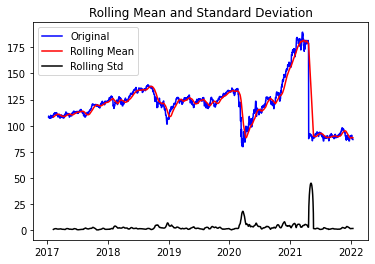

Results of dickey fuller test
Test Statistics                  -2.451701
p-value                           0.127672
No. of lags used                  0.000000
Number of observations used    1824.000000
critical value (1%)              -3.433940
critical value (5%)              -2.863126
critical value (10%)             -2.567614
dtype: float64



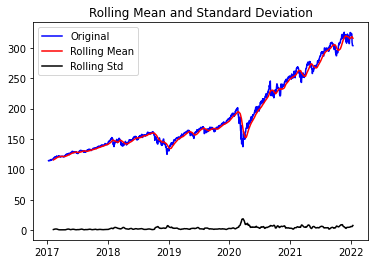

Results of dickey fuller test
Test Statistics                   0.222539
p-value                           0.973498
No. of lags used                 19.000000
Number of observations used    1805.000000
critical value (1%)              -3.433978
critical value (5%)              -2.863143
critical value (10%)             -2.567623
dtype: float64



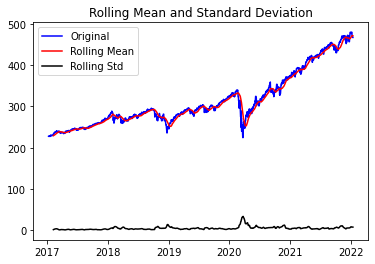

Results of dickey fuller test
Test Statistics                   0.004102
p-value                           0.958870
No. of lags used                 17.000000
Number of observations used    1807.000000
critical value (1%)              -3.433974
critical value (5%)              -2.863141
critical value (10%)             -2.567622
dtype: float64



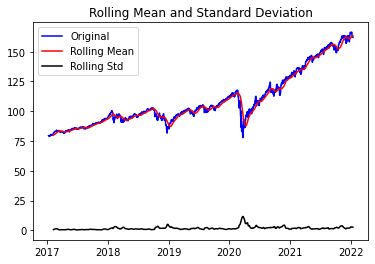

Results of dickey fuller test
Test Statistics                   0.033211
p-value                           0.961194
No. of lags used                 17.000000
Number of observations used    1807.000000
critical value (1%)              -3.433974
critical value (5%)              -2.863141
critical value (10%)             -2.567622
dtype: float64



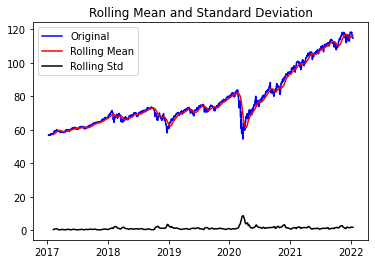

Results of dickey fuller test
Test Statistics                  -0.153793
p-value                           0.943810
No. of lags used                 17.000000
Number of observations used    1807.000000
critical value (1%)              -3.433974
critical value (5%)              -2.863141
critical value (10%)             -2.567622
dtype: float64



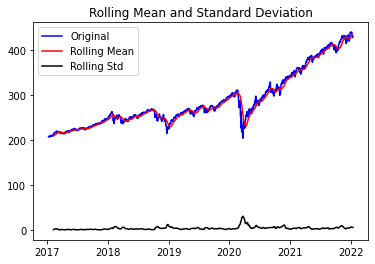

Results of dickey fuller test
Test Statistics                   0.015110
p-value                           0.959764
No. of lags used                 17.000000
Number of observations used    1807.000000
critical value (1%)              -3.433974
critical value (5%)              -2.863141
critical value (10%)             -2.567622
dtype: float64



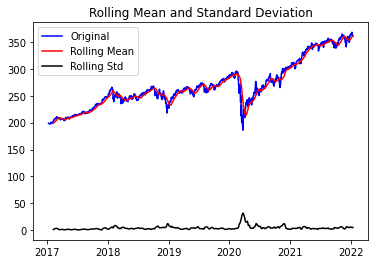

Results of dickey fuller test
Test Statistics                  -0.877786
p-value                           0.795200
No. of lags used                 17.000000
Number of observations used    1807.000000
critical value (1%)              -3.433974
critical value (5%)              -2.863141
critical value (10%)             -2.567622
dtype: float64



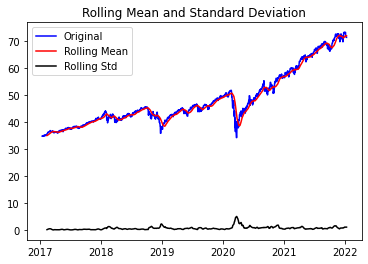

Results of dickey fuller test
Test Statistics                  -0.036674
p-value                           0.955392
No. of lags used                 17.000000
Number of observations used    1807.000000
critical value (1%)              -3.433974
critical value (5%)              -2.863141
critical value (10%)             -2.567622
dtype: float64



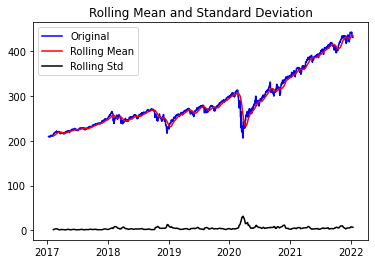

Results of dickey fuller test
Test Statistics                   0.017918
p-value                           0.959989
No. of lags used                 17.000000
Number of observations used    1807.000000
critical value (1%)              -3.433974
critical value (5%)              -2.863141
critical value (10%)             -2.567622
dtype: float64



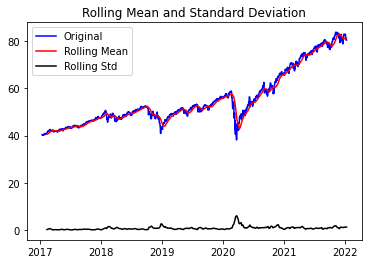

Results of dickey fuller test
Test Statistics                  -0.232525
p-value                           0.934532
No. of lags used                 17.000000
Number of observations used    1807.000000
critical value (1%)              -3.433974
critical value (5%)              -2.863141
critical value (10%)             -2.567622
dtype: float64



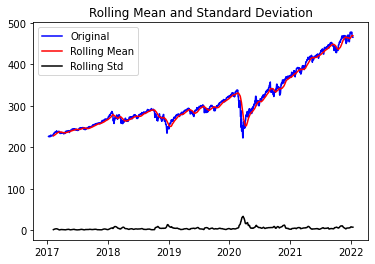

Results of dickey fuller test
Test Statistics                   0.015590
p-value                           0.959803
No. of lags used                 17.000000
Number of observations used    1807.000000
critical value (1%)              -3.433974
critical value (5%)              -2.863141
critical value (10%)             -2.567622
dtype: float64



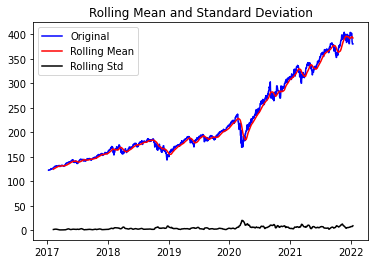

Results of dickey fuller test
Test Statistics                   0.385226
p-value                           0.980934
No. of lags used                 14.000000
Number of observations used    1810.000000
critical value (1%)              -3.433968
critical value (5%)              -2.863138
critical value (10%)             -2.567621
dtype: float64



In [17]:
for ticker in tickers:
    t = funds.loc[ticker,['close']]
    print(check_stationarity(t))

## Making Stationary Series

### Detrending Functions

In [18]:
def differenced(tick,k,test=False):
    ts = funds.loc[tick,['close']]
    ts_diff = ts.diff(k).dropna()
    if test == True:
        print(f"Differencing Results For {tick}:")
        print(check_stationarity(ts_diff));
    else:
        return ts_diff
    return ""

In [19]:
def decompose(z,target,plot=False,check=False):
    ts = funds.loc[z,[target]]
    decomposition = seasonal_decompose(ts,period=30)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    if plot == True:
        plt.figure(figsize=(18,10))
        plt.subplot(411)
        plt.plot(ts, label='Original', color='blue')
        plt.legend(loc='best')
        plt.subplot(412)
        plt.plot(trend, label='Trend', color='blue')
        plt.legend(loc='best')
        plt.subplot(413)
        plt.plot(seasonal,label='Seasonality', color='blue')
        plt.legend(loc='best')
        plt.subplot(414)
        plt.plot(residual, label='Residuals', color='blue')
        plt.legend(loc='best')
        plt.tight_layout()
        
    ts_decompose = residual
    ts_decompose.dropna(inplace=True)
    
    if check == True:
        check_stationarity(ts_decompose)
        return ""
    
    return ts_decompose
        

### Differencing

Differencing Results For NASDX:


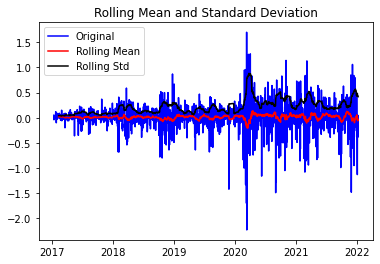

Results of dickey fuller test
Test Statistics               -1.136831e+01
p-value                        9.110303e-21
No. of lags used               1.200000e+01
Number of observations used    1.811000e+03
critical value (1%)           -3.433966e+00
critical value (5%)           -2.863137e+00
critical value (10%)          -2.567620e+00
dtype: float64


Differencing Results For VTWO:


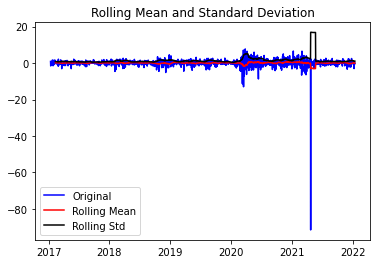

Results of dickey fuller test
Test Statistics                 -44.001070
p-value                           0.000000
No. of lags used                  0.000000
Number of observations used    1823.000000
critical value (1%)              -3.433942
critical value (5%)              -2.863127
critical value (10%)             -2.567615
dtype: float64


Differencing Results For VUG:


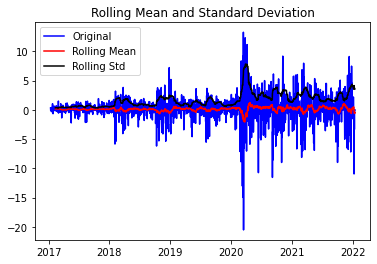

Results of dickey fuller test
Test Statistics               -9.787878e+00
p-value                        6.470296e-17
No. of lags used               1.800000e+01
Number of observations used    1.805000e+03
critical value (1%)           -3.433978e+00
critical value (5%)           -2.863143e+00
critical value (10%)          -2.567623e+00
dtype: float64


Differencing Results For IVV:


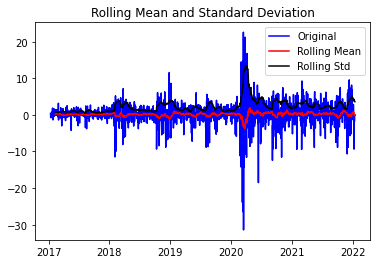

Results of dickey fuller test
Test Statistics               -9.713095e+00
p-value                        9.994045e-17
No. of lags used               1.600000e+01
Number of observations used    1.807000e+03
critical value (1%)           -3.433974e+00
critical value (5%)           -2.863141e+00
critical value (10%)          -2.567622e+00
dtype: float64


Differencing Results For FXAIX:


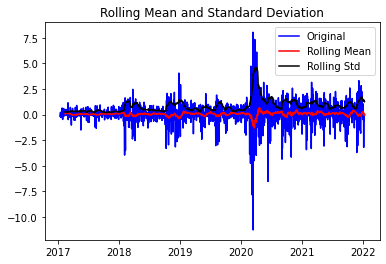

Results of dickey fuller test
Test Statistics               -9.756619e+00
p-value                        7.758888e-17
No. of lags used               1.600000e+01
Number of observations used    1.807000e+03
critical value (1%)           -3.433974e+00
critical value (5%)           -2.863141e+00
critical value (10%)          -2.567622e+00
dtype: float64


Differencing Results For VTSAX:


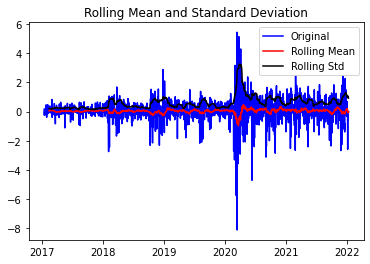

Results of dickey fuller test
Test Statistics               -9.686132e+00
p-value                        1.169270e-16
No. of lags used               1.600000e+01
Number of observations used    1.807000e+03
critical value (1%)           -3.433974e+00
critical value (5%)           -2.863141e+00
critical value (10%)          -2.567622e+00
dtype: float64


Differencing Results For VOO:


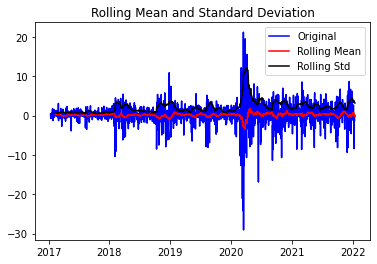

Results of dickey fuller test
Test Statistics               -9.723499e+00
p-value                        9.406937e-17
No. of lags used               1.600000e+01
Number of observations used    1.807000e+03
critical value (1%)           -3.433974e+00
critical value (5%)           -2.863141e+00
critical value (10%)          -2.567622e+00
dtype: float64


Differencing Results For DIA:


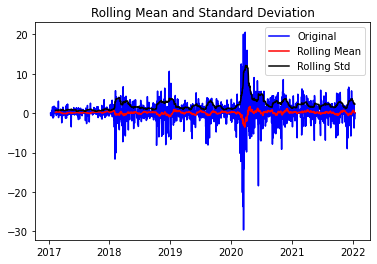

Results of dickey fuller test
Test Statistics               -1.015728e+01
p-value                        7.670662e-18
No. of lags used               1.600000e+01
Number of observations used    1.807000e+03
critical value (1%)           -3.433974e+00
critical value (5%)           -2.863141e+00
critical value (10%)          -2.567622e+00
dtype: float64


Differencing Results For SWPPX:


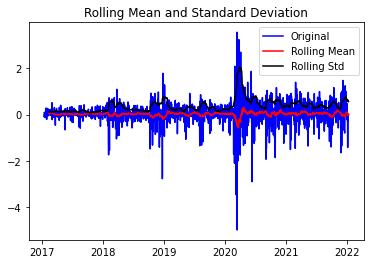

Results of dickey fuller test
Test Statistics               -9.794276e+00
p-value                        6.234307e-17
No. of lags used               1.600000e+01
Number of observations used    1.807000e+03
critical value (1%)           -3.433974e+00
critical value (5%)           -2.863141e+00
critical value (10%)          -2.567622e+00
dtype: float64


Differencing Results For VFIAX:


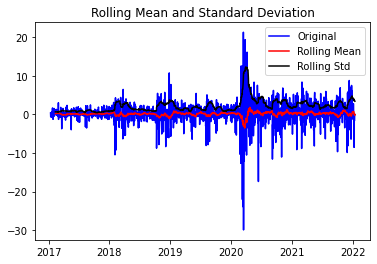

Results of dickey fuller test
Test Statistics               -9.749613e+00
p-value                        8.081425e-17
No. of lags used               1.600000e+01
Number of observations used    1.807000e+03
critical value (1%)           -3.433974e+00
critical value (5%)           -2.863141e+00
critical value (10%)          -2.567622e+00
dtype: float64


Differencing Results For SWTSX:


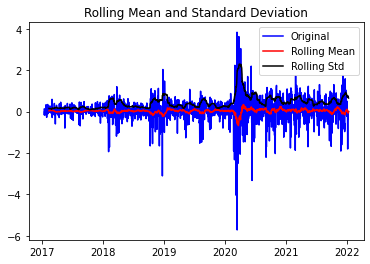

Results of dickey fuller test
Test Statistics               -9.757357e+00
p-value                        7.725675e-17
No. of lags used               1.600000e+01
Number of observations used    1.807000e+03
critical value (1%)           -3.433974e+00
critical value (5%)           -2.863141e+00
critical value (10%)          -2.567622e+00
dtype: float64


Differencing Results For SPY:


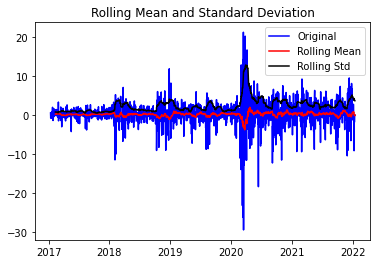

Results of dickey fuller test
Test Statistics               -9.714208e+00
p-value                        9.929535e-17
No. of lags used               1.600000e+01
Number of observations used    1.807000e+03
critical value (1%)           -3.433974e+00
critical value (5%)           -2.863141e+00
critical value (10%)          -2.567622e+00
dtype: float64


Differencing Results For QQQ:


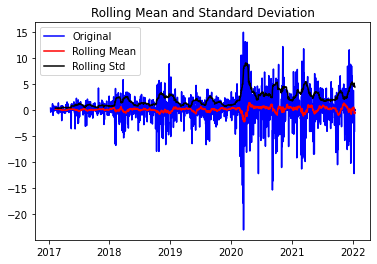

Results of dickey fuller test
Test Statistics               -1.133568e+01
p-value                        1.085201e-20
No. of lags used               1.200000e+01
Number of observations used    1.811000e+03
critical value (1%)           -3.433966e+00
critical value (5%)           -2.863137e+00
critical value (10%)          -2.567620e+00
dtype: float64




In [20]:
for ticker in tickers:
    print(differenced(ticker,1,True))

All p-values are less than the alpha of 0.05. This tells us that we can reject the null hypothesis, that the time series are non-stationary, in favor of the alternative which is that the time series are stationary.

In [21]:
VFIAX_diff = differenced('VFIAX',1)
IVV_diff = differenced('IVV',1)
VTSAX_diff = differenced('VTSAX',1)
QQQ_diff = differenced('QQQ',1)
SWPPX_diff = differenced('SWPPX',1)
SWTSX_diff = differenced('SWTSX',1)
FXAIX_diff = differenced('FXAIX',1)
NASDX_diff = differenced('NASDX',1)
DIA_diff = differenced('DIA',1)
VUG_diff = differenced('VUG',1)
SPY_diff = differenced('SPY',1)
VOO_diff = differenced('VOO',1)

### Decomposition

Decomposition Results For NASDX:



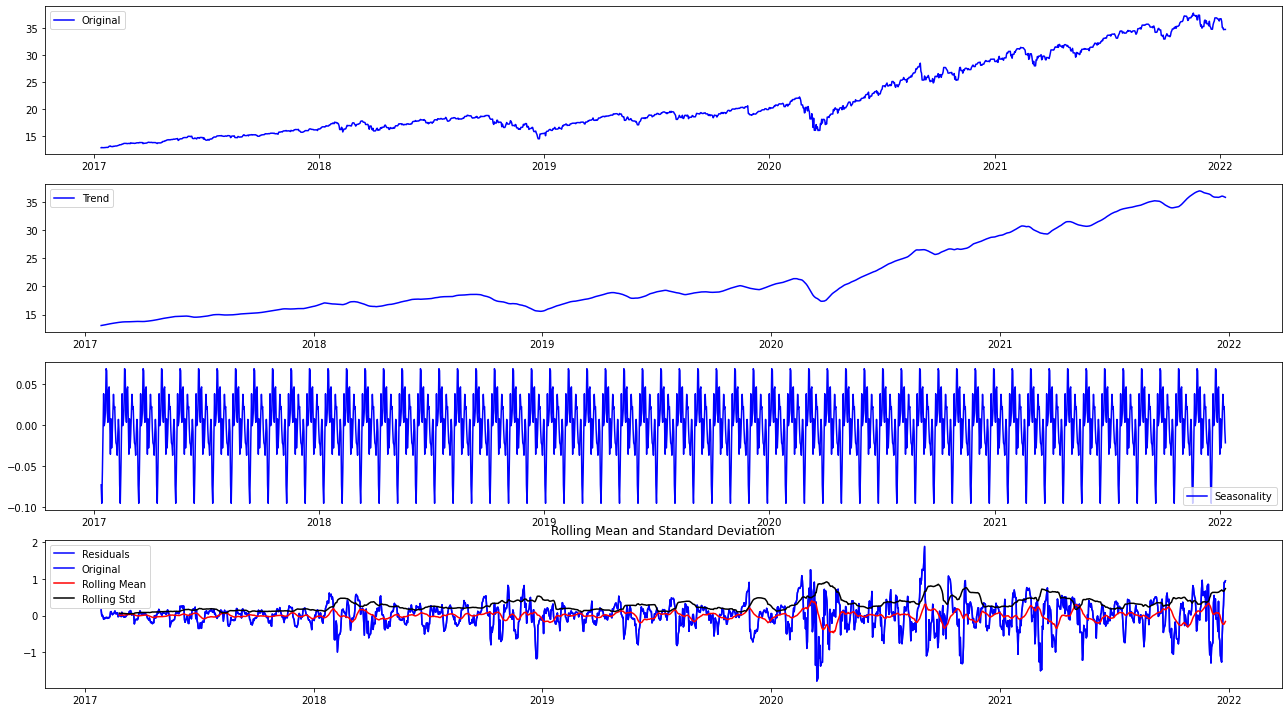

Results of dickey fuller test
Test Statistics               -1.208403e+01
p-value                        2.198619e-22
No. of lags used               1.600000e+01
Number of observations used    1.778000e+03
critical value (1%)           -3.434033e+00
critical value (5%)           -2.863167e+00
critical value (10%)          -2.567636e+00
dtype: float64


Decomposition Results For VTWO:



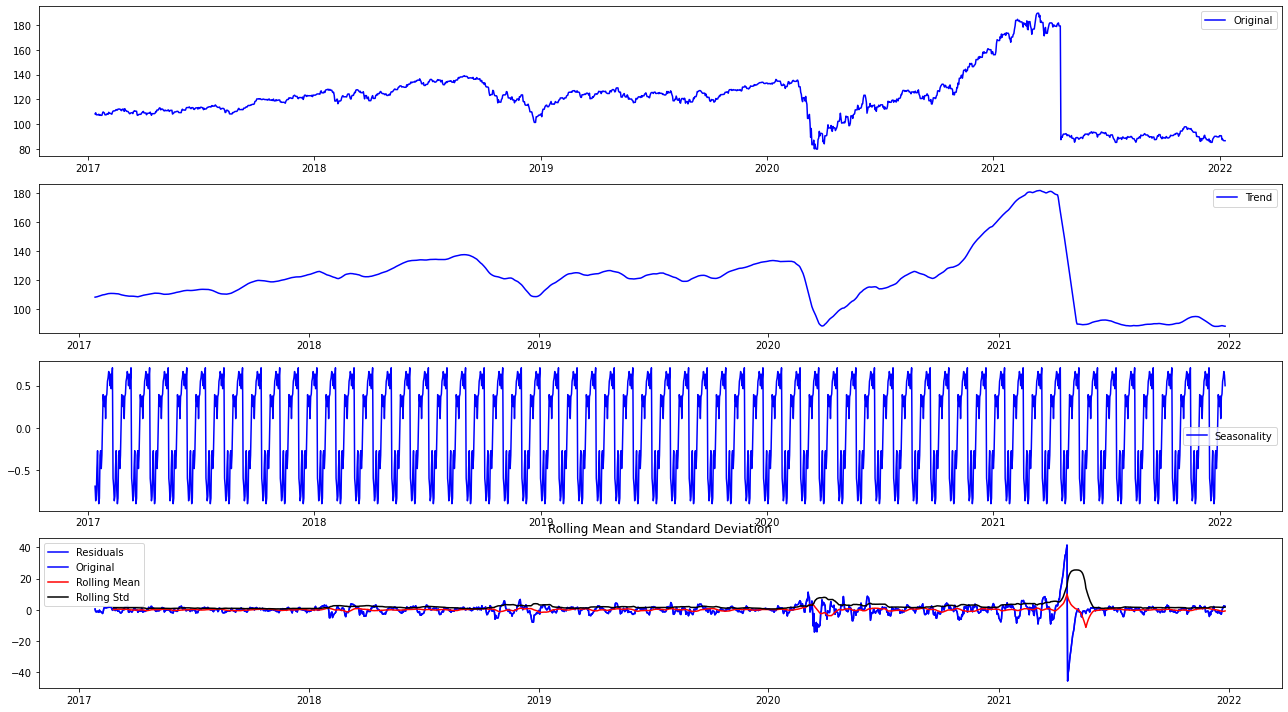

Results of dickey fuller test
Test Statistics               -1.279286e+01
p-value                        7.016060e-24
No. of lags used               1.800000e+01
Number of observations used    1.776000e+03
critical value (1%)           -3.434037e+00
critical value (5%)           -2.863169e+00
critical value (10%)          -2.567637e+00
dtype: float64


Decomposition Results For VUG:



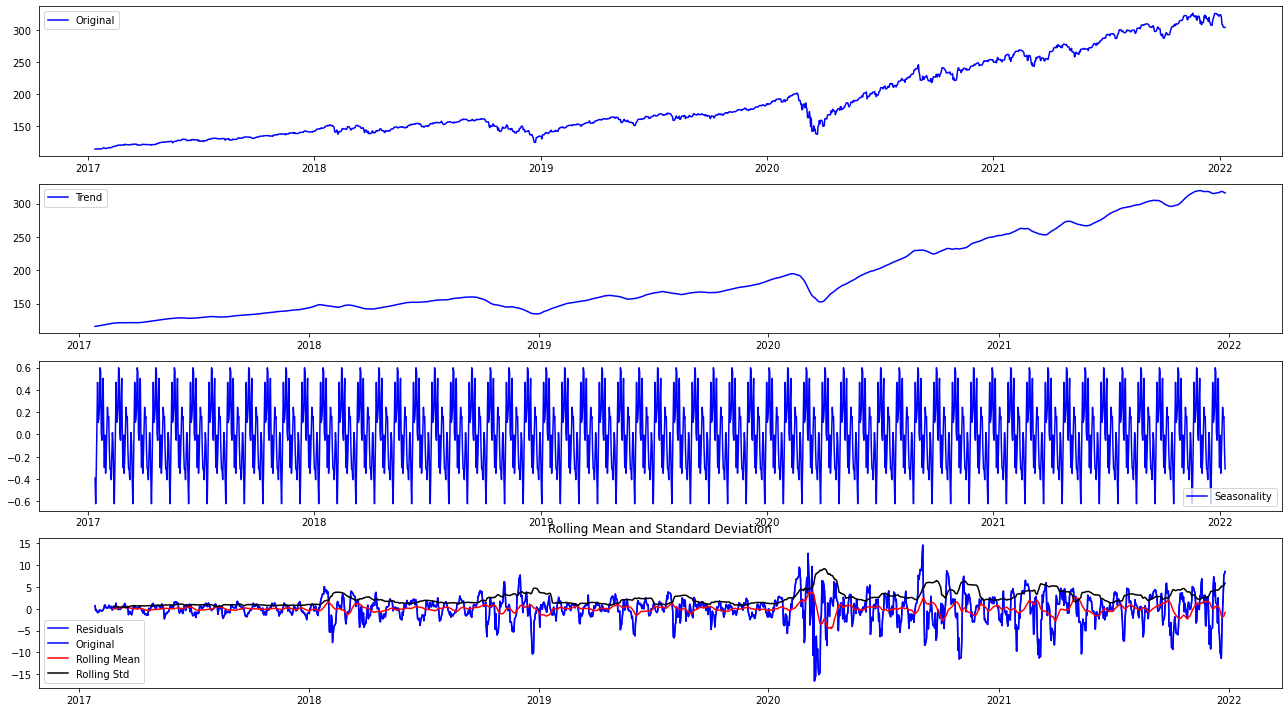

Results of dickey fuller test
Test Statistics               -1.085454e+01
p-value                        1.499207e-19
No. of lags used               2.500000e+01
Number of observations used    1.769000e+03
critical value (1%)           -3.434052e+00
critical value (5%)           -2.863175e+00
critical value (10%)          -2.567641e+00
dtype: float64


Decomposition Results For IVV:



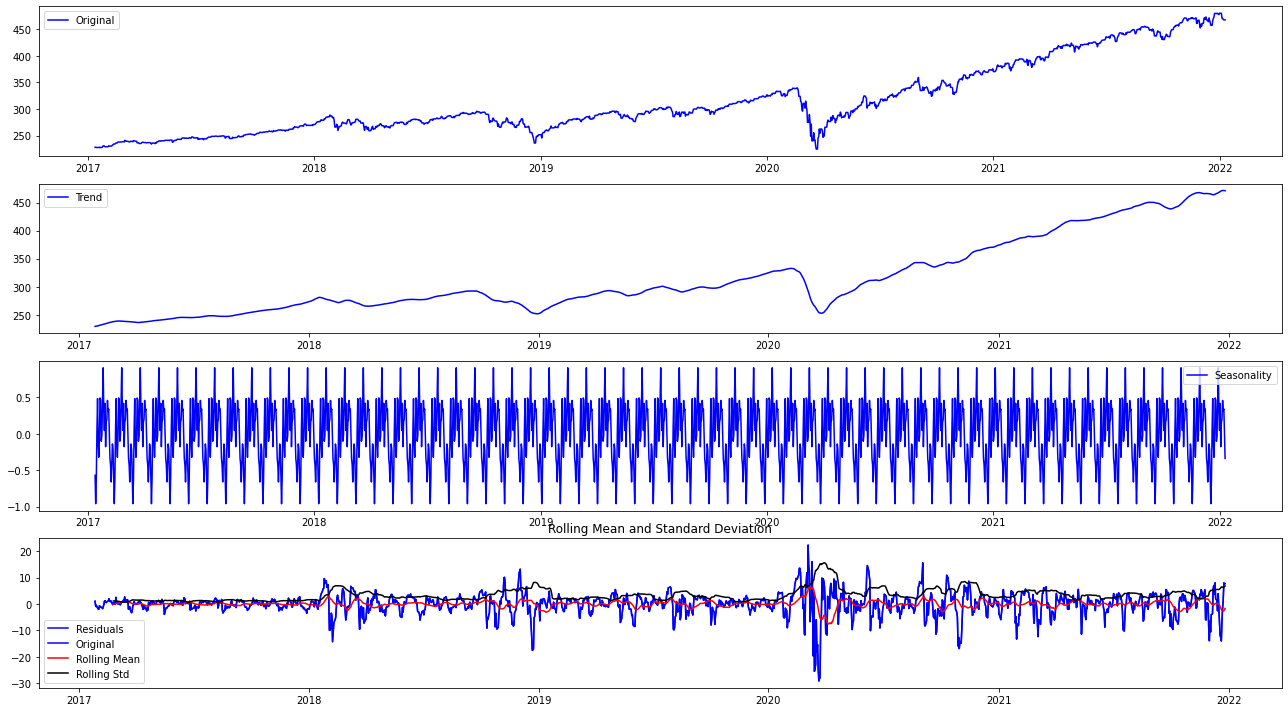

Results of dickey fuller test
Test Statistics               -1.235532e+01
p-value                        5.703587e-23
No. of lags used               1.600000e+01
Number of observations used    1.778000e+03
critical value (1%)           -3.434033e+00
critical value (5%)           -2.863167e+00
critical value (10%)          -2.567636e+00
dtype: float64


Decomposition Results For FXAIX:



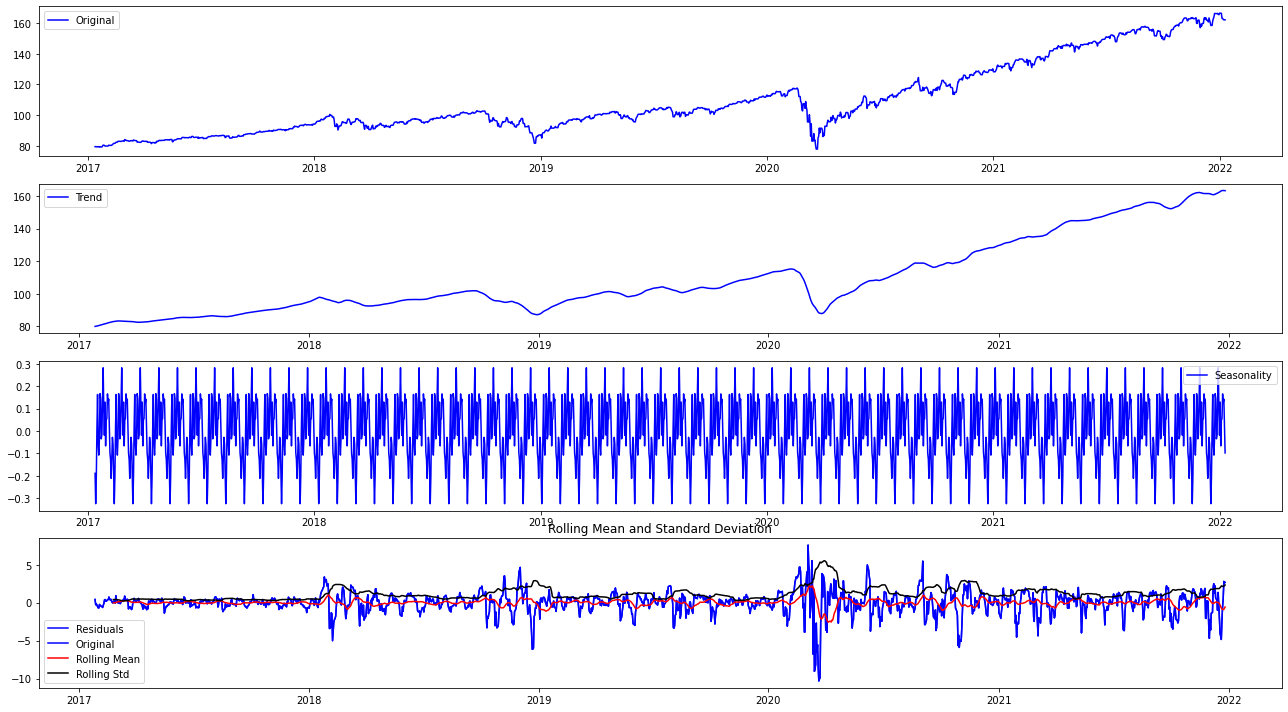

Results of dickey fuller test
Test Statistics               -1.234644e+01
p-value                        5.957611e-23
No. of lags used               1.600000e+01
Number of observations used    1.778000e+03
critical value (1%)           -3.434033e+00
critical value (5%)           -2.863167e+00
critical value (10%)          -2.567636e+00
dtype: float64


Decomposition Results For VTSAX:



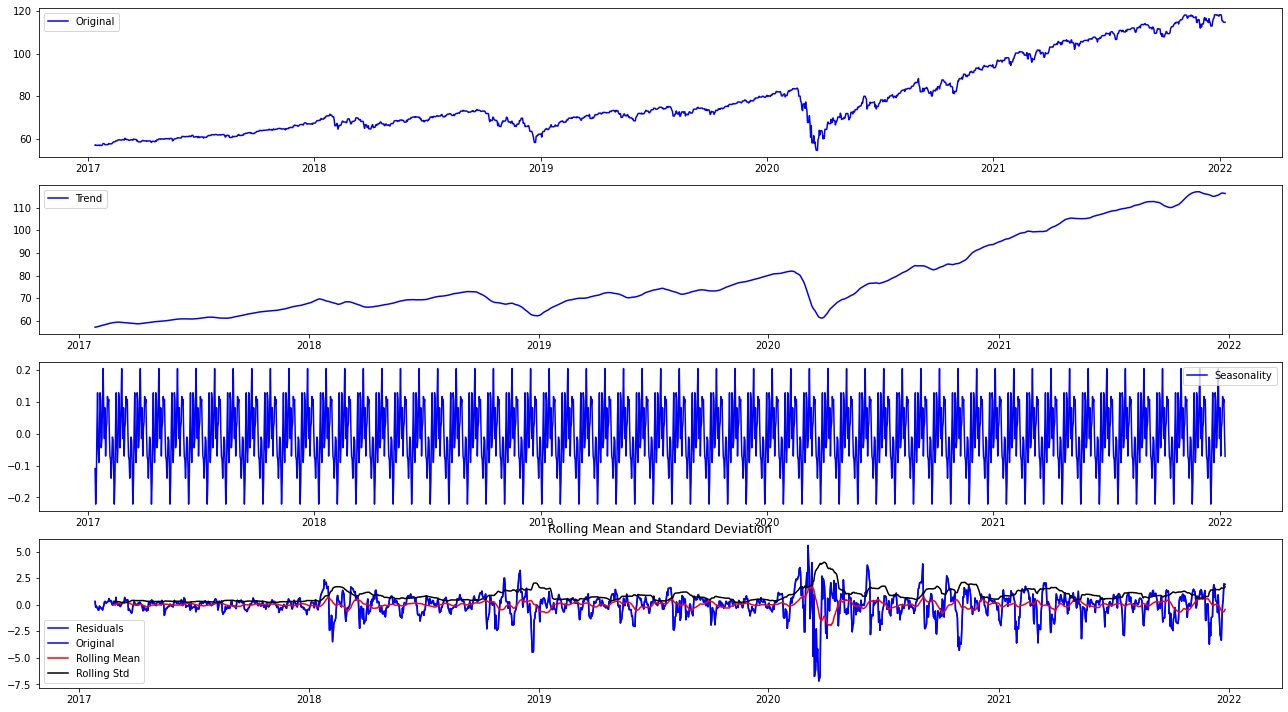

Results of dickey fuller test
Test Statistics               -1.231584e+01
p-value                        6.925287e-23
No. of lags used               1.600000e+01
Number of observations used    1.778000e+03
critical value (1%)           -3.434033e+00
critical value (5%)           -2.863167e+00
critical value (10%)          -2.567636e+00
dtype: float64


Decomposition Results For VOO:



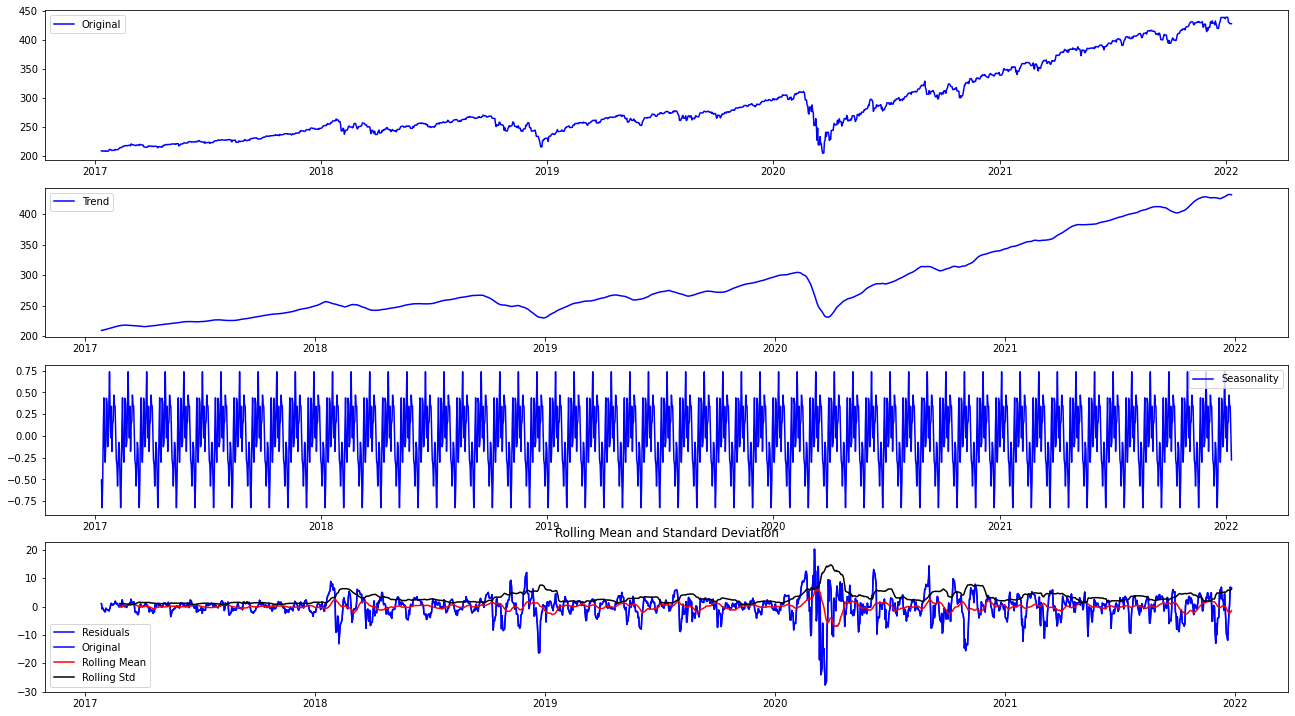

Results of dickey fuller test
Test Statistics               -1.234785e+01
p-value                        5.916595e-23
No. of lags used               1.600000e+01
Number of observations used    1.778000e+03
critical value (1%)           -3.434033e+00
critical value (5%)           -2.863167e+00
critical value (10%)          -2.567636e+00
dtype: float64


Decomposition Results For DIA:



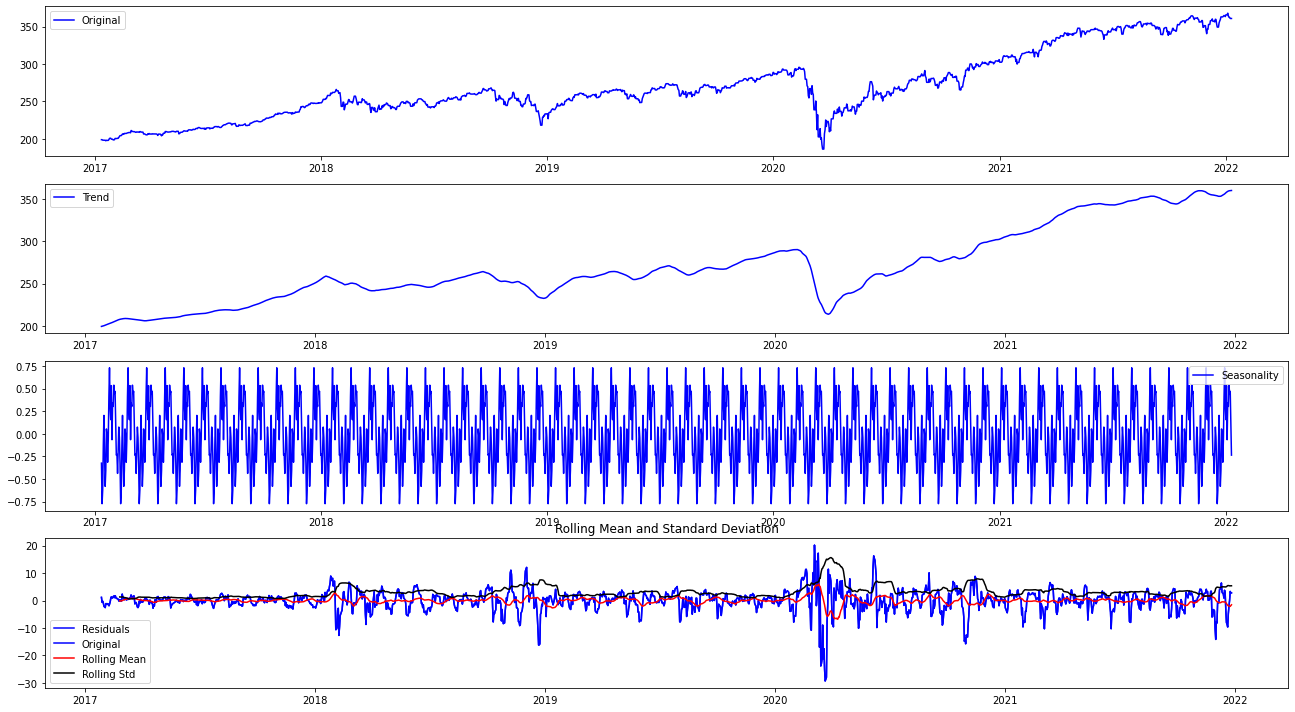

Results of dickey fuller test
Test Statistics               -1.269836e+01
p-value                        1.093527e-23
No. of lags used               1.600000e+01
Number of observations used    1.778000e+03
critical value (1%)           -3.434033e+00
critical value (5%)           -2.863167e+00
critical value (10%)          -2.567636e+00
dtype: float64


Decomposition Results For SWPPX:



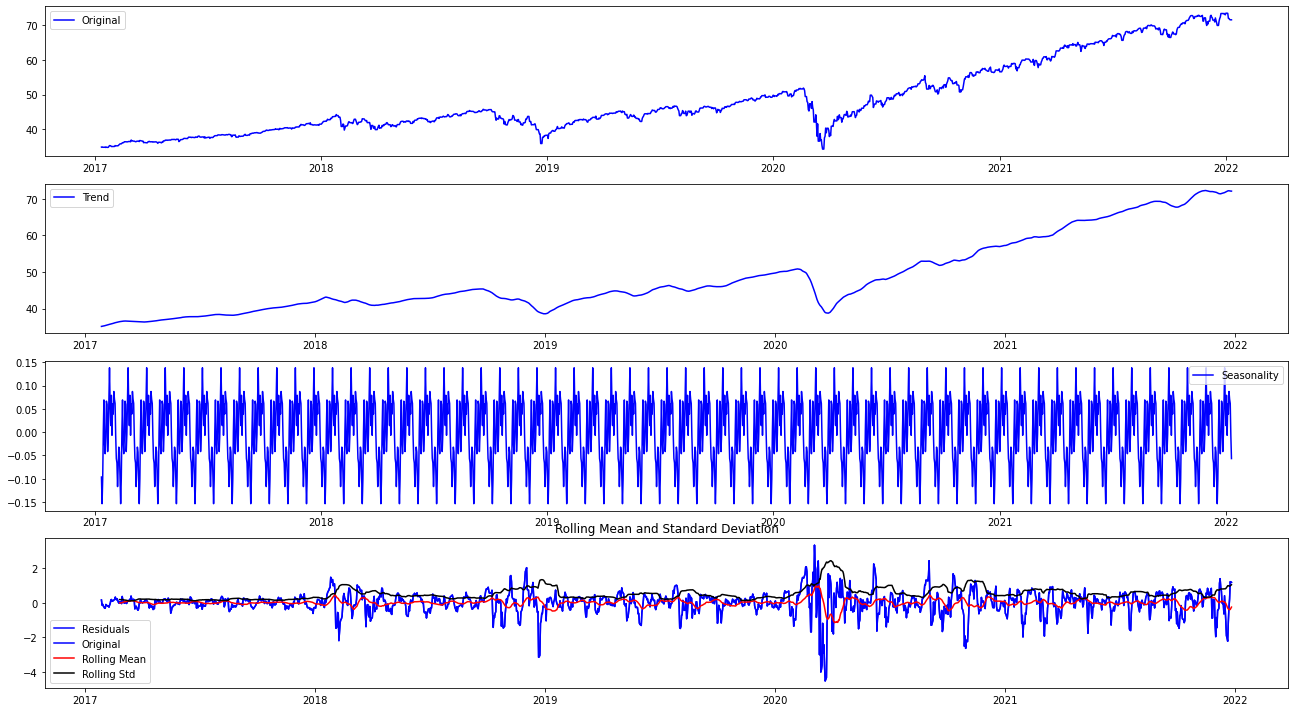

Results of dickey fuller test
Test Statistics               -1.232967e+01
p-value                        6.469373e-23
No. of lags used               1.600000e+01
Number of observations used    1.778000e+03
critical value (1%)           -3.434033e+00
critical value (5%)           -2.863167e+00
critical value (10%)          -2.567636e+00
dtype: float64


Decomposition Results For VFIAX:



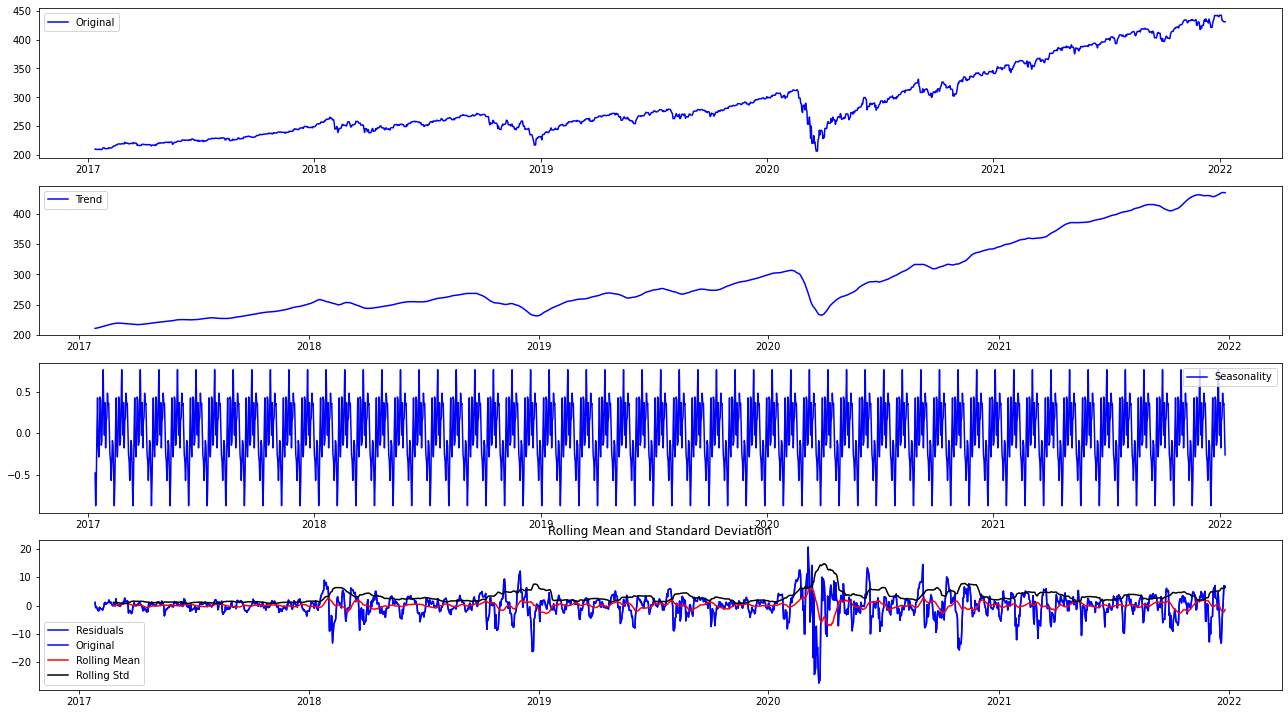

Results of dickey fuller test
Test Statistics               -1.234748e+01
p-value                        5.927306e-23
No. of lags used               1.600000e+01
Number of observations used    1.778000e+03
critical value (1%)           -3.434033e+00
critical value (5%)           -2.863167e+00
critical value (10%)          -2.567636e+00
dtype: float64


Decomposition Results For SWTSX:



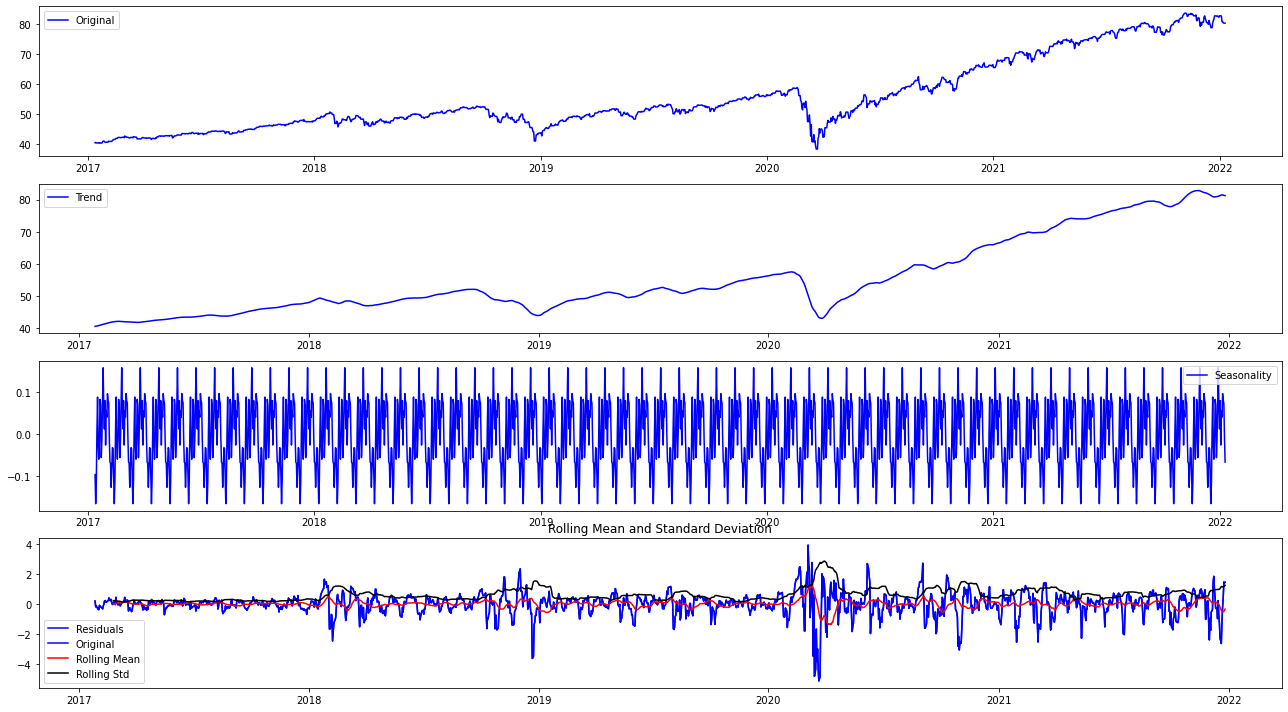

Results of dickey fuller test
Test Statistics               -1.234217e+01
p-value                        6.083862e-23
No. of lags used               1.600000e+01
Number of observations used    1.778000e+03
critical value (1%)           -3.434033e+00
critical value (5%)           -2.863167e+00
critical value (10%)          -2.567636e+00
dtype: float64


Decomposition Results For SPY:



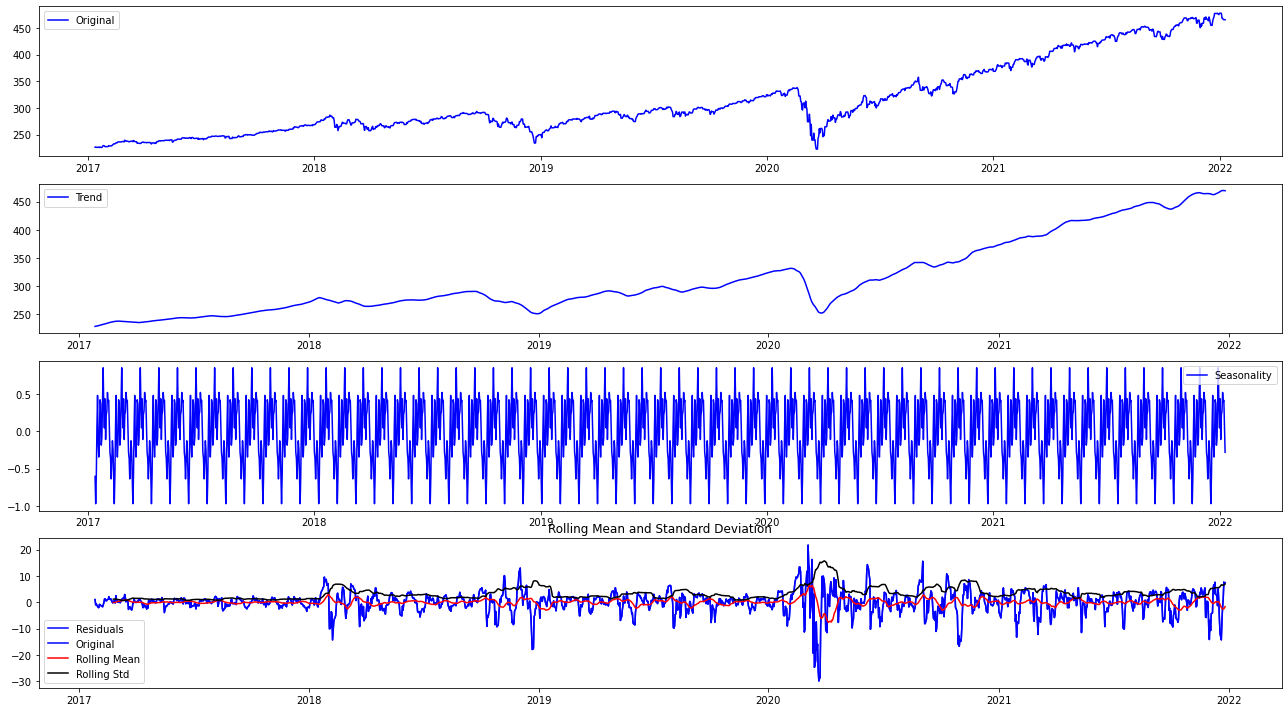

Results of dickey fuller test
Test Statistics               -1.231066e+01
p-value                        7.104098e-23
No. of lags used               1.600000e+01
Number of observations used    1.778000e+03
critical value (1%)           -3.434033e+00
critical value (5%)           -2.863167e+00
critical value (10%)          -2.567636e+00
dtype: float64


Decomposition Results For QQQ:



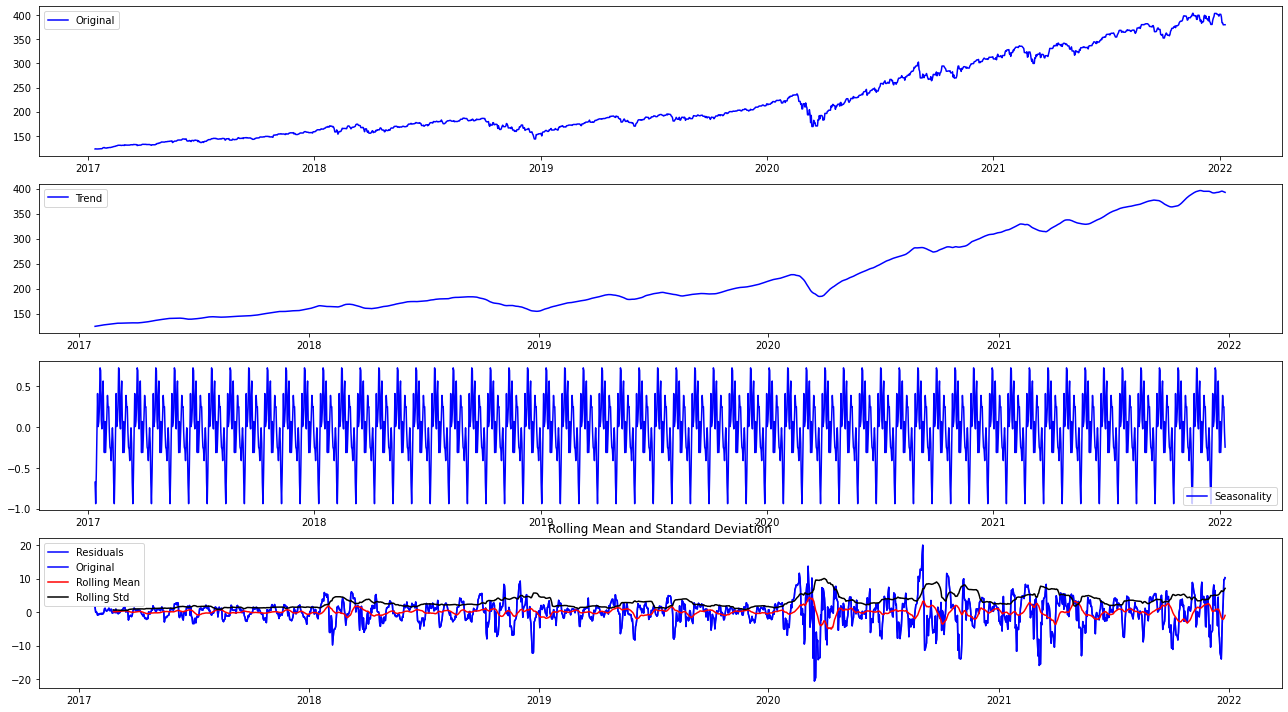

Results of dickey fuller test
Test Statistics               -1.169798e+01
p-value                        1.593724e-21
No. of lags used               1.800000e+01
Number of observations used    1.776000e+03
critical value (1%)           -3.434037e+00
critical value (5%)           -2.863169e+00
critical value (10%)          -2.567637e+00
dtype: float64




In [22]:
for tick in tickers:
    print(f"Decomposition Results For {tick}:")
    print()
    print(decompose(tick,'close',plot=True,check=True))
    print()

Decomposition also yields all stationary time series.

In [23]:
# Stationary Index Funds Time Series

VFIAX_stationary = decompose('VFIAX', 'close')
IVV_stationary = decompose('IVV','close')
VTSAX_stationary = decompose('VTSAX', 'close')
QQQ_stationary = decompose('QQQ', 'close')
SWPPX_stationary = decompose('SWPPX', 'close')
SWTSX_stationary = decompose('SWTSX', 'close')
FXAIX_stationary = decompose('FXAIX', 'close')
NASDX_stationary = decompose('NASDX', 'close')
DIA_stationary = decompose('DIA', 'close')
VUG_stationary = decompose('VUG', 'close')
SPY_stationary = decompose('SPY', 'close')
VOO_stationary = decompose('VOO', 'close')

### Train Test Split

In [24]:
def train_test_splt(ts,test_size):
    cutoff = int(ts.shape[0]*(1-test_size))
    train = ts[:cutoff]
    test = ts[cutoff:]
    return train, test

In [25]:
VFIAX_train, VFIAX_test = train_test_splt(VFIAX,.3)
IVV_train, IVV_test = train_test_splt(IVV,.3)
VTSAX_train, VTSAX_test = train_test_splt(VTSAX,.3)
QQQ_train, QQQ_test = train_test_splt(QQQ,.3)
SWPPX_train, SWPPX_test = train_test_splt(SWPPX,.3)
SWTSX_train, SWTSX_test = train_test_splt(SWTSX,.3)
FXAIX_train, FXIAX_test = train_test_splt(FXAIX,.3)
NASDX_train, NASDX_test = train_test_splt(NASDX,.3)
DIA_train, DIA_test = train_test_splt(DIA,.3)
VUG_train, VUG_test = train_test_splt(VUG,.3)
SPY_train, SPY_test = train_test_splt(SPY,.3)
VOO_train, VOO_test = train_test_splt(VOO,.3)

# VFIAX

### Baseline "Naive" Model

In [26]:
def baseline_model(ts,shift,show=False):
    base = ts.shift(shift)
    
    if show == True:
        
        fig, ax = plt.subplots(figsize=(10,4))
        ax.set_title("Baseline Forecast")
        ax.plot(ts,c='b',label='Actual')
        ax.plot(base,c='r',label='Baseline')
        plt.legend()
        plt.show()
        return None
    return base       

In [27]:
VFIAX_baseline = baseline_model(VFIAX,30)
VFIAX_base_rmse = mean_squared_error(VFIAX,VFIAX_baseline.bfill(),squared=False)
VFIAX_base_rmse

14.322246932848191

In [28]:
VFIAX_baseline.isna().sum()

close    30
dtype: int64

In [29]:
VFIAX_baseline.iloc[29,:]

close   NaN
Name: 2017-02-10 00:00:00+00:00, dtype: float64

In [30]:
VFIAX_baseline.iloc[30,:]

close    209.63
Name: 2017-02-11 00:00:00+00:00, dtype: float64

In [31]:
mean_squared_error(VFIAX_baseline[30:],VFIAX[30:],squared=False)

14.439642558404438

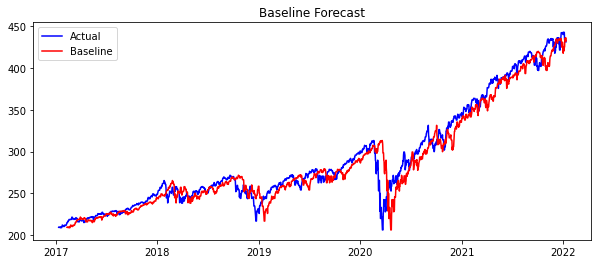

In [32]:
baseline_model(VFIAX,30,True)

In [33]:
# new approach to baseline

In [34]:
new_df = pd.DataFrame()

In [35]:
new_df['original'] = VFIAX['close']

In [36]:
new_df['shifted'] = VFIAX['close'].shift(30)

In [37]:
new_df

,original,shifted
date,,
2017-01-12 00:00:00+00:00,209.63,NaN
2017-01-13 00:00:00+00:00,210.01,NaN
2017-01-14 00:00:00+00:00,209.39,NaN
2017-01-15 00:00:00+00:00,209.39,NaN
2017-01-16 00:00:00+00:00,209.39,NaN
...,...,...
2022-01-06 00:00:00+00:00,433.45,433.72
2022-01-07 00:00:00+00:00,431.77,435.08
2022-01-08 00:00:00+00:00,431.15,432.00


In [38]:
cutoff = int(len(new_df['original']) * 0.70)

In [39]:
original = new_df['original']
shifted = new_df['shifted']
original_train, original_test = original[30:cutoff], original[cutoff:]
shifted_train, shifted_test = shifted[30:cutoff], shifted[cutoff:]

In [40]:
mean_squared_error(original_train,shifted_train,squared=False)

15.01296033790331

In [41]:
mean_squared_error(original_test,shifted_test,squared=False)

13.04143641191918

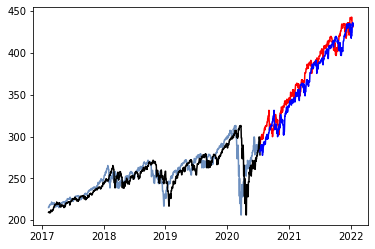

In [42]:
plt.plot(original_train,)
plt.plot(original_test,c='r')
plt.plot(shifted_train,c='black')
plt.plot(shifted_test,c='blue')
plt.show()

### ARIMA Model

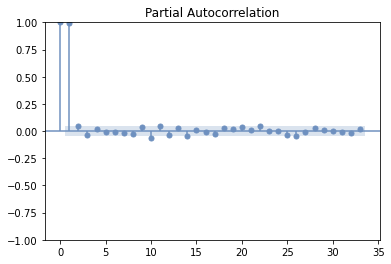

In [43]:
plot_pacf(VFIAX);

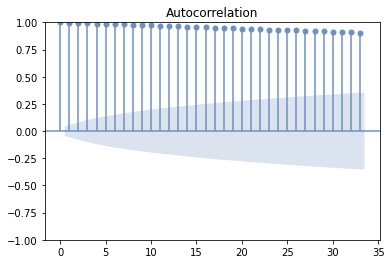

In [44]:
plot_acf(VFIAX);

In [45]:
def get_combos(n,k):
    p = d = q = range(n, k)
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]
    return pdqs

In [46]:
def get_optimal_params(ts,n,k):
    pdq = get_combos(n,k)
    ans = []
    for comb in pdq:
        try:
            model = ARIMA(ts,
                         order=comb)
            output = model.fit()
            ans.append([comb,output.aic])
        except:
            continue
    ans_df = pd.DataFrame(ans, columns=['pdq','aic'])
    optimals = ans_df.loc[ans_df['aic'].idxmin()]
    return optimals

In [47]:
def arima_models(ts,n,k):
    order = get_optimal_params(ts,n,k)['pdq']
    model = ARIMA(ts,
                 order=order)
    output = model.fit()
    return output

In [48]:
# Find optimal pdq
print(get_optimal_params(VFIAX_train,0,3))

# Fit ARIMA with optimal pdq
arima_model = arima_models(VFIAX_train,0,3)

# Summary of model
arima_model.summary()

pdq    (2, 1, 2)
aic      6145.87
Name: 23, dtype: object


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1277
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3067.933
Date:                Tue, 18 Jan 2022   AIC                           6145.866
Time:                        11:25:13   BIC                           6171.623
Sample:                    01-12-2017   HQIC                          6155.539
                         - 07-11-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8133      0.011   -168.441      0.000      -1.834      -1.792
ar.L2         -0.9480      0.010    -93.033      0.000      -0.968      -0.928
ma.L1          1.7476      0.013    133.627      0.000       1.722       1.773
ma.L2          0.9090      0.012     76.867      0.000       0.886       0.932
sigma2         7.1728      0.100     71.422      0.000       6.976       7.370
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):             26277.92
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               9.24   Skew:                            -1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

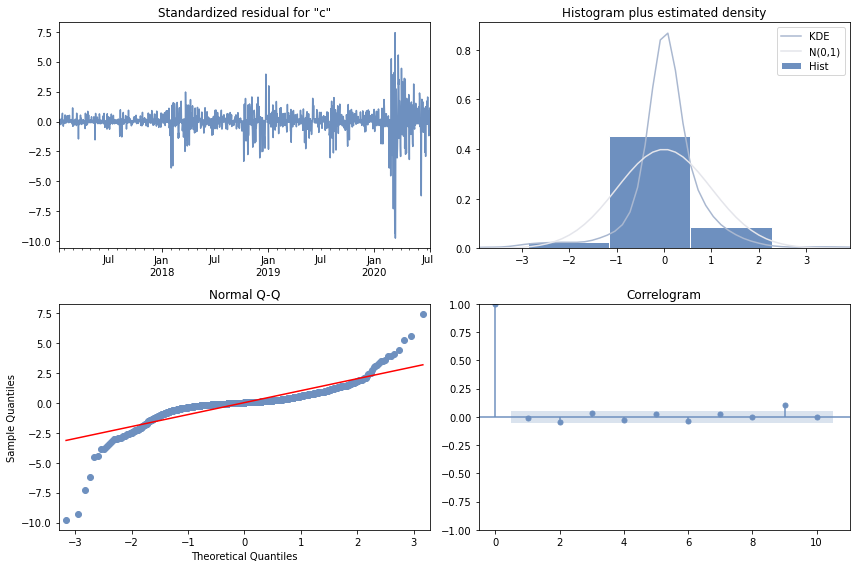

In [49]:
arima_model.plot_diagnostics(figsize=(12,8))
plt.tight_layout();

From the KDE plot and qqplot, we can see that the residuals are not quite normally distributed. The KDE plot shows that the distribution is slightly skewed with most of the density centered around the mean. The qqplot shows that the residuals do not follow a linear trend which is an indication that the residuals are not normal. 

### ARIMA RMSEs

In [50]:
# time steps in test set
VFIAX_test.shape

(548, 1)

In [51]:
# predictions for next 548 days
steps = 548
fc = arima_model.forecast(steps)

In [52]:
VFIAX_train.tail()

,close
date,
2020-07-07 00:00:00+00:00,290.32
2020-07-08 00:00:00+00:00,292.59
2020-07-09 00:00:00+00:00,291.02
2020-07-10 00:00:00+00:00,294.07
2020-07-11 00:00:00+00:00,291.32


In [53]:
fc.head()

2020-07-12 00:00:00+00:00    291.693556
2020-07-13 00:00:00+00:00    291.300867
2020-07-14 00:00:00+00:00    291.658772
2020-07-15 00:00:00+00:00    291.382079
2020-07-16 00:00:00+00:00    291.544489
Freq: D, Name: predicted_mean, dtype: float64

In [68]:
fc.tail()

2022-01-06 00:00:00+00:00    291.494999
2022-01-07 00:00:00+00:00    291.494999
2022-01-08 00:00:00+00:00    291.494999
2022-01-09 00:00:00+00:00    291.494999
2022-01-10 00:00:00+00:00    291.494999
Freq: D, Name: predicted_mean, dtype: float64

In [69]:
VFIAX_test.head()

,close
date,
2020-07-12 00:00:00+00:00,291.32
2020-07-13 00:00:00+00:00,291.32
2020-07-14 00:00:00+00:00,295.26
2020-07-15 00:00:00+00:00,297.95
2020-07-16 00:00:00+00:00,296.94


In [70]:
VFIAX_test.tail()

,close
date,
2022-01-06 00:00:00+00:00,433.45
2022-01-07 00:00:00+00:00,431.77
2022-01-08 00:00:00+00:00,431.15
2022-01-09 00:00:00+00:00,431.15
2022-01-10 00:00:00+00:00,431.15


In [54]:
# compare between forecasted 548 days and the actual 548 days which are the test data
mean_squared_error(VFIAX_test,fc,squared=False)

90.92881969616928

In [55]:
def find_rmse(model, test_data):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

In [56]:
find_rmse(arima_model,VFIAX_test)

90.92881969616928

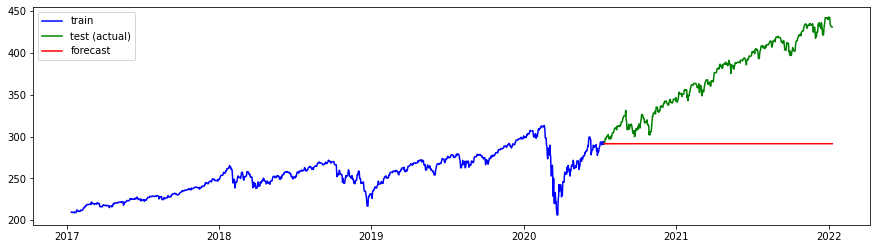

In [71]:
plt.figure(figsize=(15,4))
plt.plot(VFIAX_train,c="blue",label='train')
plt.plot(VFIAX_test,c='green',label='test (actual)')
plt.plot(fc, c='red',label='forecast')
plt.legend()
plt.show()

### SARIMAX model

In [72]:
p = d = q = range(0,3)
pdq = list(itertools.product(p,d,q))
pdqs = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(VFIAX_train,
                          order=comb,
                          seasonal_order=combs,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('SARIMA {} x {} : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue    

SARIMA (0, 0, 0) x (0, 0, 0, 30) : AIC Calculated =17770.34464474097
SARIMA (0, 0, 0) x (0, 0, 1, 30) : AIC Calculated =15800.71207324149
SARIMA (0, 0, 0) x (0, 0, 2, 30) : AIC Calculated =14282.285485003189
SARIMA (0, 0, 0) x (0, 1, 0, 30) : AIC Calculated =10289.46521604035
SARIMA (0, 0, 0) x (0, 1, 1, 30) : AIC Calculated =10002.495955374045
SARIMA (0, 0, 0) x (0, 1, 2, 30) : AIC Calculated =9707.4506573343
SARIMA (0, 0, 0) x (0, 2, 0, 30) : AIC Calculated =11099.928384271905
SARIMA (0, 0, 0) x (0, 2, 1, 30) : AIC Calculated =9921.103453423137
SARIMA (0, 0, 0) x (0, 2, 2, 30) : AIC Calculated =9623.997778537947
SARIMA (0, 0, 0) x (1, 0, 0, 30) : AIC Calculated =10288.401343606187
SARIMA (0, 0, 0) x (1, 0, 1, 30) : AIC Calculated =10199.506637079821
SARIMA (0, 0, 0) x (1, 0, 2, 30) : AIC Calculated =9756.828507390952
SARIMA (0, 0, 0) x (1, 1, 0, 30) : AIC Calculated =10033.535361497907
SARIMA (0, 0, 0) x (1, 1, 1, 30) : AIC Calculated =9931.820217632063
SARIMA (0, 0, 0) x (1, 1, 2, 3

SARIMA (0, 1, 1) x (1, 0, 2, 30) : AIC Calculated =5973.550026187072
SARIMA (0, 1, 1) x (1, 1, 0, 30) : AIC Calculated =6417.269499349223
SARIMA (0, 1, 1) x (1, 1, 1, 30) : AIC Calculated =6032.543994974494
SARIMA (0, 1, 1) x (1, 1, 2, 30) : AIC Calculated =5903.30460399101
SARIMA (0, 1, 1) x (1, 2, 0, 30) : AIC Calculated =7168.72339657548
SARIMA (0, 1, 1) x (1, 2, 1, 30) : AIC Calculated =6390.802639295148
SARIMA (0, 1, 1) x (1, 2, 2, 30) : AIC Calculated =5952.208773524219
SARIMA (0, 1, 1) x (2, 0, 0, 30) : AIC Calculated =5980.758153533634
SARIMA (0, 1, 1) x (2, 0, 1, 30) : AIC Calculated =5981.927949665775
SARIMA (0, 1, 1) x (2, 0, 2, 30) : AIC Calculated =5975.534736102619
SARIMA (0, 1, 1) x (2, 1, 0, 30) : AIC Calculated =6202.536906423604
SARIMA (0, 1, 1) x (2, 1, 1, 30) : AIC Calculated =5921.392913970282
SARIMA (0, 1, 1) x (2, 1, 2, 30) : AIC Calculated =5905.30206052062
SARIMA (0, 1, 1) x (2, 2, 0, 30) : AIC Calculated =6731.13677007815
SARIMA (0, 1, 1) x (2, 2, 1, 30) : AIC

SARIMA (0, 2, 2) x (2, 1, 1, 30) : AIC Calculated =5928.4040668014495
SARIMA (0, 2, 2) x (2, 1, 2, 30) : AIC Calculated =5907.000990789184
SARIMA (0, 2, 2) x (2, 2, 0, 30) : AIC Calculated =6735.633859040435
SARIMA (0, 2, 2) x (2, 2, 1, 30) : AIC Calculated =6195.986103313748
SARIMA (0, 2, 2) x (2, 2, 2, 30) : AIC Calculated =5966.662850264691
SARIMA (1, 0, 0) x (0, 0, 0, 30) : AIC Calculated =6237.9400192482035
SARIMA (1, 0, 0) x (0, 0, 1, 30) : AIC Calculated =6121.102291692518
SARIMA (1, 0, 0) x (0, 0, 2, 30) : AIC Calculated =6001.4753348264
SARIMA (1, 0, 0) x (0, 1, 0, 30) : AIC Calculated =6955.5958225838185
SARIMA (1, 0, 0) x (0, 1, 1, 30) : AIC Calculated =6056.417118152307
SARIMA (1, 0, 0) x (0, 1, 2, 30) : AIC Calculated =5937.097594562558
SARIMA (1, 0, 0) x (0, 2, 0, 30) : AIC Calculated =8143.439624847818
SARIMA (1, 0, 0) x (0, 2, 1, 30) : AIC Calculated =6768.420705992648
SARIMA (1, 0, 0) x (0, 2, 2, 30) : AIC Calculated =5969.743823420435
SARIMA (1, 0, 0) x (1, 0, 0, 30) 

SARIMA (1, 1, 1) x (0, 2, 0, 30) : AIC Calculated =8114.432889895325
SARIMA (1, 1, 1) x (0, 2, 1, 30) : AIC Calculated =6738.762425984569
SARIMA (1, 1, 1) x (0, 2, 2, 30) : AIC Calculated =5940.007676049527
SARIMA (1, 1, 1) x (1, 0, 0, 30) : AIC Calculated =6086.135059696457
SARIMA (1, 1, 1) x (1, 0, 1, 30) : AIC Calculated =6084.23202164817
SARIMA (1, 1, 1) x (1, 0, 2, 30) : AIC Calculated =5964.441773736332
SARIMA (1, 1, 1) x (1, 1, 0, 30) : AIC Calculated =6403.440565893367
SARIMA (1, 1, 1) x (1, 1, 1, 30) : AIC Calculated =6022.06928422151
SARIMA (1, 1, 1) x (1, 1, 2, 30) : AIC Calculated =5894.333845382346
SARIMA (1, 1, 1) x (1, 2, 0, 30) : AIC Calculated =7155.221812922002
SARIMA (1, 1, 1) x (1, 2, 1, 30) : AIC Calculated =6381.640935145042
SARIMA (1, 1, 1) x (1, 2, 2, 30) : AIC Calculated =5942.00694418248
SARIMA (1, 1, 1) x (2, 0, 0, 30) : AIC Calculated =5967.4450985895355
SARIMA (1, 1, 1) x (2, 0, 1, 30) : AIC Calculated =5968.871177446593
SARIMA (1, 1, 1) x (2, 0, 2, 30) : A

SARIMA (1, 2, 2) x (1, 2, 2, 30) : AIC Calculated =5946.568787202638
SARIMA (1, 2, 2) x (2, 0, 0, 30) : AIC Calculated =5971.237469233819
SARIMA (1, 2, 2) x (2, 0, 1, 30) : AIC Calculated =5972.40805081886
SARIMA (1, 2, 2) x (2, 0, 2, 30) : AIC Calculated =5965.4084025045295
SARIMA (1, 2, 2) x (2, 1, 0, 30) : AIC Calculated =6191.290702157854
SARIMA (1, 2, 2) x (2, 1, 1, 30) : AIC Calculated =5914.48791170054
SARIMA (1, 2, 2) x (2, 1, 2, 30) : AIC Calculated =5897.964528847377
SARIMA (1, 2, 2) x (2, 2, 0, 30) : AIC Calculated =6719.777494226455
SARIMA (1, 2, 2) x (2, 2, 1, 30) : AIC Calculated =6178.891463040232
SARIMA (1, 2, 2) x (2, 2, 2, 30) : AIC Calculated =5954.697041462728
SARIMA (2, 0, 0) x (0, 0, 0, 30) : AIC Calculated =6210.724868075431
SARIMA (2, 0, 0) x (0, 0, 1, 30) : AIC Calculated =6098.346038460037
SARIMA (2, 0, 0) x (0, 0, 2, 30) : AIC Calculated =5979.237117591774
SARIMA (2, 0, 0) x (0, 1, 0, 30) : AIC Calculated =6928.070273430548
SARIMA (2, 0, 0) x (0, 1, 1, 30) : 

SARIMA (2, 1, 1) x (0, 0, 1, 30) : AIC Calculated =6083.609972784384
SARIMA (2, 1, 1) x (0, 0, 2, 30) : AIC Calculated =5964.432864164761
SARIMA (2, 1, 1) x (0, 1, 0, 30) : AIC Calculated =6921.860152013496
SARIMA (2, 1, 1) x (0, 1, 1, 30) : AIC Calculated =6021.76084654045
SARIMA (2, 1, 1) x (0, 1, 2, 30) : AIC Calculated =5903.512172636447
SARIMA (2, 1, 1) x (0, 2, 0, 30) : AIC Calculated =8108.775411445267
SARIMA (2, 1, 1) x (0, 2, 1, 30) : AIC Calculated =6735.609245442208
SARIMA (2, 1, 1) x (0, 2, 2, 30) : AIC Calculated =5942.061768283701
SARIMA (2, 1, 1) x (1, 0, 0, 30) : AIC Calculated =6083.608892990089
SARIMA (2, 1, 1) x (1, 0, 1, 30) : AIC Calculated =6085.607719795331
SARIMA (2, 1, 1) x (1, 0, 2, 30) : AIC Calculated =5965.801214675076
SARIMA (2, 1, 1) x (1, 1, 0, 30) : AIC Calculated =6398.806184222929
SARIMA (2, 1, 1) x (1, 1, 1, 30) : AIC Calculated =6023.7601800974135
SARIMA (2, 1, 1) x (1, 1, 2, 30) : AIC Calculated =5896.227607891521
SARIMA (2, 1, 1) x (1, 2, 0, 30) :

SARIMA (2, 2, 2) x (1, 1, 0, 30) : AIC Calculated =6376.815231959917
SARIMA (2, 2, 2) x (1, 1, 1, 30) : AIC Calculated =6011.366478549556
SARIMA (2, 2, 2) x (1, 1, 2, 30) : AIC Calculated =5882.760601335518
SARIMA (2, 2, 2) x (1, 2, 0, 30) : AIC Calculated =7149.910795202715
SARIMA (2, 2, 2) x (1, 2, 1, 30) : AIC Calculated =6384.902272730493
SARIMA (2, 2, 2) x (1, 2, 2, 30) : AIC Calculated =5948.557330360958
SARIMA (2, 2, 2) x (2, 0, 0, 30) : AIC Calculated =5963.542700368657
SARIMA (2, 2, 2) x (2, 0, 1, 30) : AIC Calculated =5964.334964321265
SARIMA (2, 2, 2) x (2, 0, 2, 30) : AIC Calculated =5961.164842780147
SARIMA (2, 2, 2) x (2, 1, 0, 30) : AIC Calculated =6165.31939324642
SARIMA (2, 2, 2) x (2, 1, 1, 30) : AIC Calculated =5897.251175026896
SARIMA (2, 2, 2) x (2, 1, 2, 30) : AIC Calculated =5900.99675791779
SARIMA (2, 2, 2) x (2, 2, 0, 30) : AIC Calculated =6688.65031742043
SARIMA (2, 2, 2) x (2, 2, 1, 30) : AIC Calculated =6174.790119555465
SARIMA (2, 2, 2) x (2, 2, 2, 30) : AI

In [73]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (2, 1, 2)
pdqs    (0, 1, 2, 30)
aic            5823.3
Name: 626, dtype: object

In [74]:
sarima_model = SARIMAX(VFIAX_train,
                      order = (2,1,2),
                      seasonal_order = (0,1,2,30),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
output = sarima_model.fit()

In [75]:
sarima_fc = output.forecast(steps)

In [76]:
mean_squared_error(VFIAX_test,sarima_fc,squared=False)

71.35551693687151

### Facebook Prophet Model

In [58]:
from fbprophet import Prophet

In [59]:
model = Prophet(interval_width=0.95,weekly_seasonality=True, daily_seasonality=True)

In [60]:
VFIAX_copy = VFIAX.copy()
VFIAX_copy.rename(columns={'close':'y'},inplace=True)
VFIAX_copy.index.name = 'ds'
VFIAX_copy = VFIAX_copy.reset_index()
VFIAX_copy['ds'] = VFIAX_copy['ds'].apply(lambda x: x.replace(tzinfo=None))

In [61]:
model.fit(VFIAX_copy)

In [62]:
future = model.make_future_dataframe(periods=90,freq='D')

In [63]:
forecast = model.predict(future)

In [64]:
forecast[['ds','yhat']].describe()

,yhat
count,1915.000000
mean,297.535689
std,69.766889
min,208.455701
25%,248.978909
50%,268.777261
75%,337.176108
max,470.019691


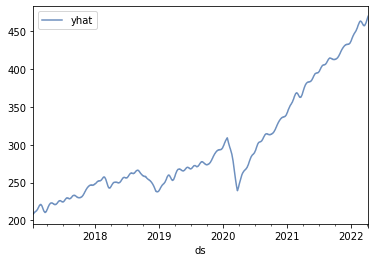

In [65]:
forecast_plot = forecast[['ds','yhat']]
forecast_plot = forecast_plot.set_index('ds')
forecast_plot.plot();

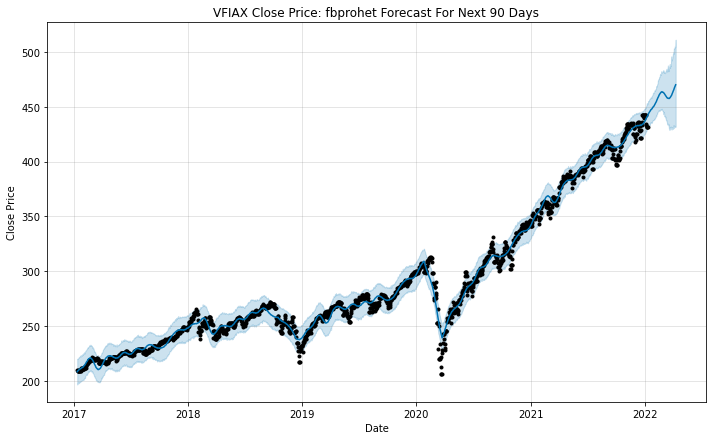

In [66]:
model.plot(forecast, uncertainty=True)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('VFIAX Close Price: fbprohet Forecast For Next 90 Days')
plt.show()

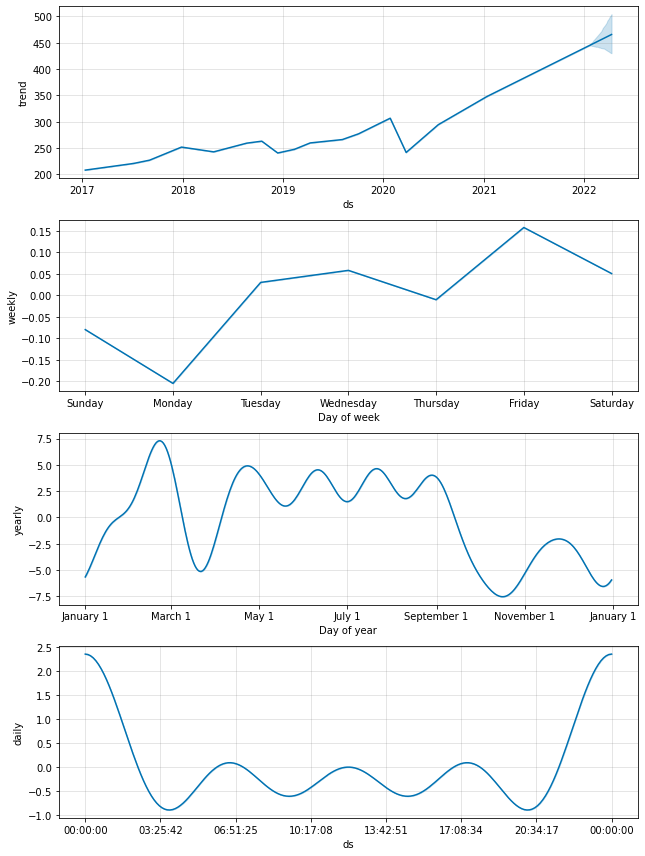

In [67]:
model.plot_components(forecast)
plt.show()